In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

/home/24m1518/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/24m1518/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-08-10 00:26:44.838735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754765804.857452 3768481 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754765804.863255 3768481 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

In [2]:
# -------------------------
# 1. Load dataset
# -------------------------
df = pd.read_csv("stock_price_data.csv",skiprows=2,names=["Date", "AMZ", "DPZ", "BTC", "NFLX"],header=None)  
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

In [3]:
df.set_index('Date',inplace=True)

In [4]:
df.head()

,AMZ,DPZ,BTC,NFLX
Date,,,,
2013-05-01,248.229996,51.190983,106.250000,30.415714
2013-05-02,252.550003,51.987320,98.099998,30.641428
2013-05-03,258.049988,52.446388,112.900002,30.492857
2013-05-06,255.720001,53.205257,109.599998,30.098572
2013-05-07,257.730011,54.151505,113.199997,29.464285


In [5]:
df.isnull().sum()

AMZ     0
DPZ     0
BTC     0
NFLX    0
dtype: int64

In [6]:
data = df[['AMZ']].values

In [7]:
# -----------------------------
# 2. Scaling
# -----------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [8]:
# -----------------------------
# 3. Create Sequences
# -----------------------------
lookback = 60  # Number of days for LSTM to look back
X, y = [], []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape for LSTM [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [9]:
# -----------------------------
# 4. Train-Test Split
# -----------------------------
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# -----------------------------
# 5. Build LSTM Model
# -----------------------------
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

2025-08-10 00:29:04.710404: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/24m1518/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# -----------------------------
# 6. Train Model with Early Stopping
# -----------------------------
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0131 - val_loss: 0.0041
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 6.0577e-04 - val_loss: 0.0020
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 5.1378e-04 - val_loss: 0.0017
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 4.7916e-04 - val_loss: 0.0018
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 6.0166e-04 - val_loss: 0.0017
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 4.4967e-04 - val_loss: 0.0015
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 5.1914e-04 - val_loss: 0.0030
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 4.9556e-04 - val_loss: 0.0016
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 4.5717e-04 - val_loss: 0.0016
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 4.3552e-04 - val_loss: 0.0078
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 6.6574e-04 - val_loss: 0.0019
Epoch 12/100

In [12]:
# -----------------------------
# 7. Predictions
# -----------------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse scale predictions
train_pred = scaler.inverse_transform(train_pred)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred = scaler.inverse_transform(test_pred)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [13]:
# -----------------------------
# 8. Evaluation
# -----------------------------
train_rmse = np.sqrt(mean_squared_error(y_train_true, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_true, test_pred))
train_r2 = r2_score(y_train_true, train_pred)
test_r2 = r2_score(y_test_true, test_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")

Train RMSE: 15.85, R²: 0.9973
Test RMSE: 45.31, R²: 0.9144


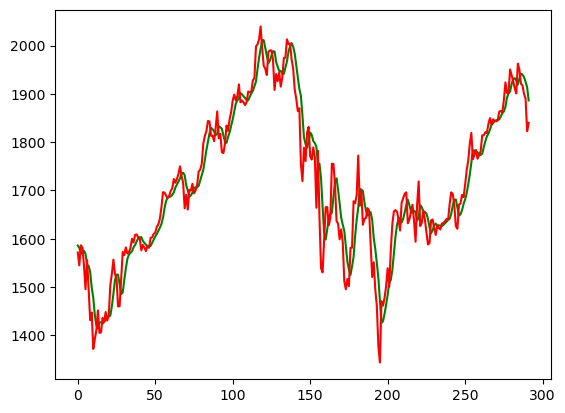

In [15]:
plt.plot(test_pred,'g',y_test_true,'r')